In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import pandas as pd
import random
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Reshape,  Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [3]:
import tensorflow as tf
print("GPUs detectadas:", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

GPUs detectadas: 0


2025-10-21 16:20:02.290535: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


[]

In [4]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    plt.show()

In [69]:
def plot_resultados(encoder, decoder, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    latente = encoder.predict(imgs_originales)[-1]
    imgs_reconstruidas = decoder.predict(latente)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Image analysis

We plot some of the images

In [47]:
# image_dir = '/kaggle/input/animefacedataset/images'

# # Load image file paths
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

# # Read images and collect their shapes
# images = []
# shapes = []
# for file in image_files:
#     img = cv2.imread(file)
#     if img is not None:
#         images.append(img)
#         shapes.append(img.shape)

# # Check if all shapes are the same
# all_same_shape = all(shape == shapes[0] for shape in shapes)
# print("All images same shape:", all_same_shape)
# print("Image shape (height, width, channels):", shapes[0])

# # Plot the first 4 images
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for i in range(min(4, len(images))):
#     img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     axs[i].imshow(img_rgb)
#     axs[i].axis('off')
#     axs[i].set_title(f'Image {i+1}')
# plt.tight_layout()
# plt.show()


In [48]:
# pd.Series(shapes).value_counts()

Shapes.value_counts()
```
(92, 92, 3)      1636
(96, 96, 3)      1556
(94, 94, 3)      1534
(95, 95, 3)      1530
(90, 90, 3)      1516
                 ... 
(87, 88, 3)         1
(220, 220, 3)       1
(126, 127, 3)       1
(101, 102, 3)       1
(181, 181, 3)       1
Name: count, Length: 181, dtype: int64
```

# VAE

## Defining Hiperparameters

In [49]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K


In [50]:
import os

# os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [61]:
# Parámetros
img_height = 64
img_width = 64
img_channels = 3
input_shape = (img_height, img_width, img_channels)
latent_dim = 128

encoder_inputs = keras.Input(shape=input_shape,)
x = Conv2D(16, 3, strides=2, padding="same")(encoder_inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, 3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, 3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, 3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(256, 3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

shape_before_flatten = K.int_shape(x)[1:]  # (2,2,256)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │        448 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │      4,640 │ activation_40[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 64)  │     18,496 │ activation_41[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ activation_42[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 2, 2, 256) │    295,168 │ activation_43[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1024)      │          0 │ activation_44[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    524,800 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,050,720 (4.01 MB)

 Trainable params: 1,049,728 (4.00 MB)

 Non-trainable params: 992 (3.88 KB)

In [62]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(1024, activation="relu")(latent_inputs)
x = Reshape(shape_before_flatten)(x)
x = Conv2DTranspose(256, 3, strides=2, padding='same')(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2DTranspose(128, 3, strides=2, padding='same')(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2DTranspose(16, 3, strides=2, padding='same')(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)

decoder_outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 4, 4, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 64, 64, 3)      │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,116,515 (4.26 MB)

 Trainable params: 1,115,523 (4.26 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
if folder:
    encoder = folder + "/Encoder.keras"

In [63]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_absolute_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)

In [64]:
vae.summary()

Model: "vae_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 128), (None,   │     1,050,720 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │     1,116,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,167,235 (8.27 MB)

 Trainable params: 2,165,251 (8.26 MB)

 Non-trainable params: 1,984 (7.75 KB)

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [55]:
image_dir = "/kaggle/input/animefacedataset"
height=64
width=64
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.01)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=256,
    class_mode=None,
    subset='training',
    shuffle=True,
    seed=2004  
)

Found 62930 images belonging to 1 classes.


In [56]:
import tensorflow as tf

def generator_to_dataset(generator, batch_size):
    # Convierte un generador Keras en un tf.data.Dataset seguro
    def _gen():
        for batch in generator:
            yield batch  # cada batch es (batch_size, 64, 64, 3)
    
    # especificamos la forma esperada de cada elemento
    output_signature = tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)

    ds = tf.data.Dataset.from_generator(_gen, output_signature=output_signature)
    
    # elimina estructuras internas raras y vuelve a empaquetar
    ds = ds.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

batch_size = 256
train_ds = generator_to_dataset(train_generator, batch_size)


## Train

In [65]:
# Fit
vae.compile(optimizer=Adam(learning_rate=1e-3))

In [77]:
h = vae.fit(train_generator, epochs=20)

Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - kl_loss: 77.2344 - loss: 1795.3971 - reconstruction_loss: 1718.1626
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 67s 272ms/step - kl_loss: 77.4750 - loss: 1792.8776 - reconstruction_loss: 1715.4025
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - kl_loss: 77.6508 - loss: 1790.6041 - reconstruction_loss: 1712.9529
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 60s 245ms/step - kl_loss: 77.9498 - loss: 1782.1288 - reconstruction_loss: 1704.1793
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 62s 252ms/step - kl_loss: 78.2811 - loss: 1781.9556 - reconstruction_loss: 1703.6748
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 63s 256ms/step - kl_loss: 78.5427 - loss: 1782.7985 - reconstruction_loss: 1704.2557
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 60s 244ms/step - kl_loss: 78.9091 - loss: 1776.7904 - reconstruction_loss: 1697.8816
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - kl_loss: 79.4165 - loss: 1777.2875 - reconstruction_loss: 1697.8707


KeyError: 'val_loss'

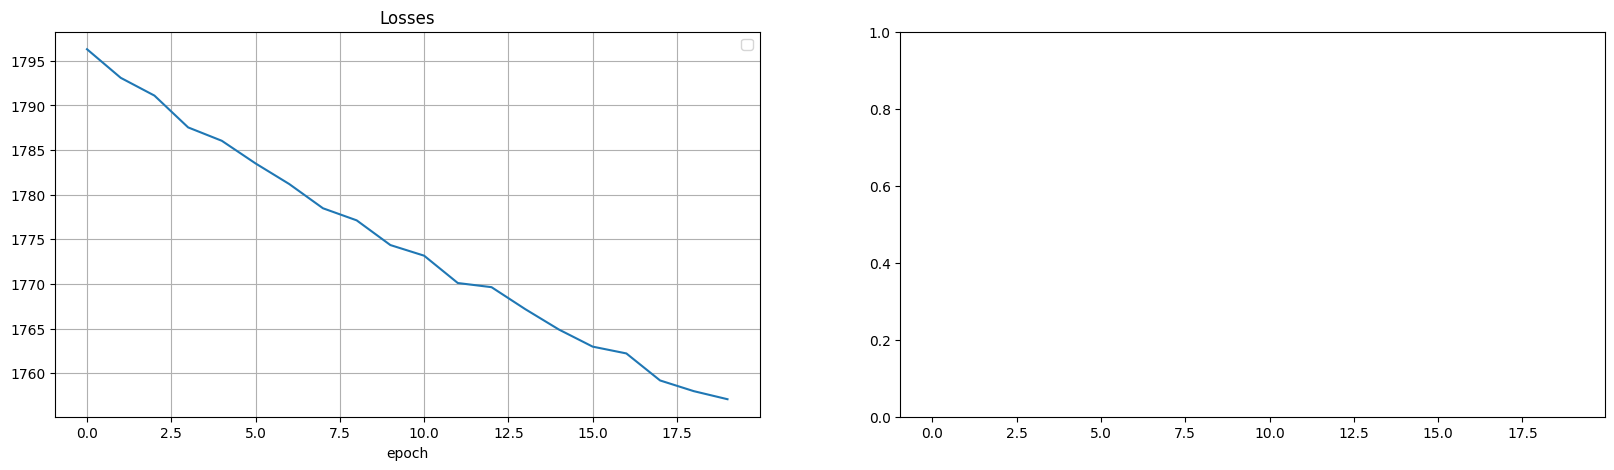

In [78]:
plot_losses(h.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


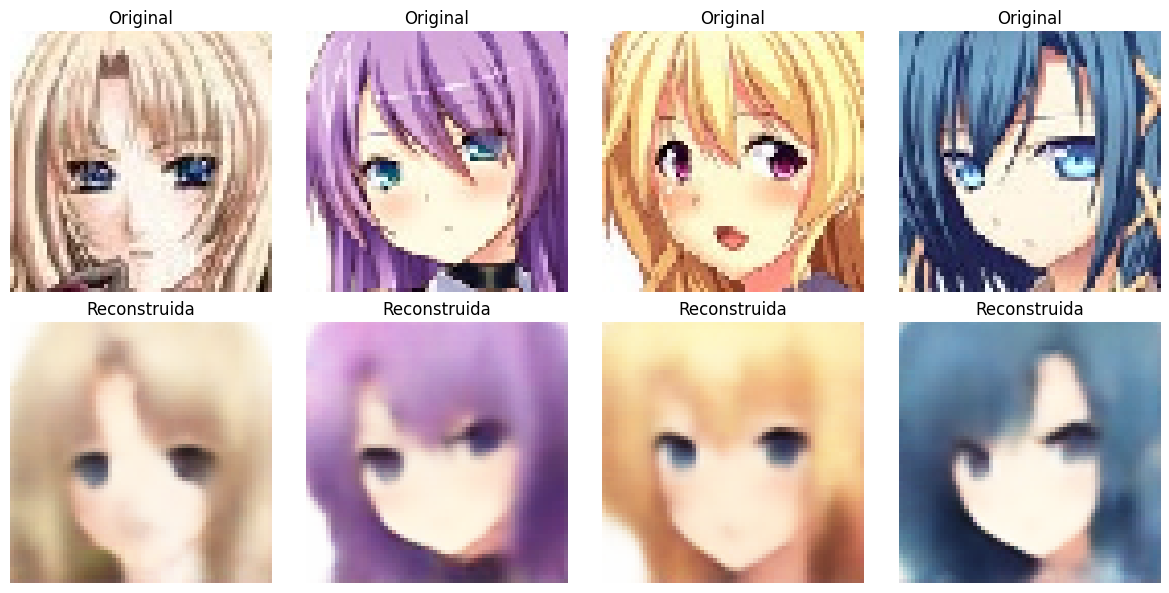

In [79]:
image_dir="/kaggle/input/animefacedataset/images"
plot_resultados(encoder, decoder,image_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


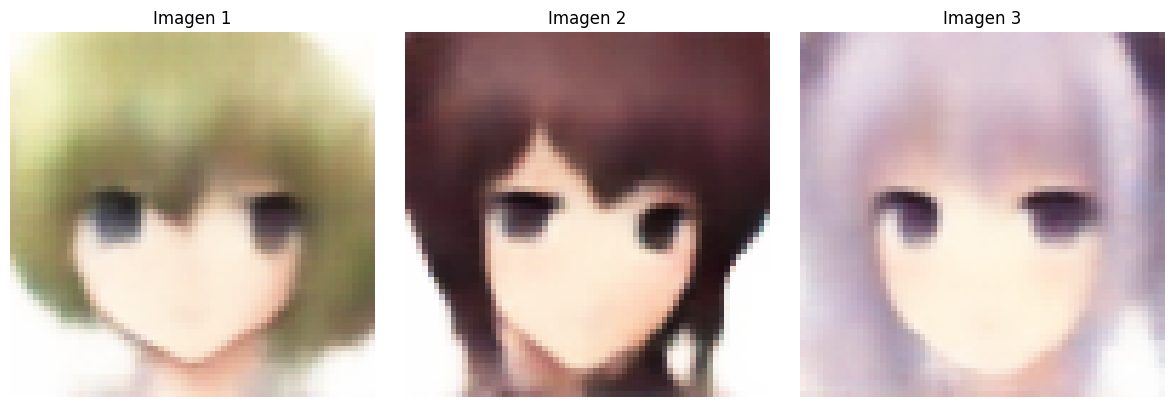

In [83]:
import matplotlib.pyplot as plt

# Genera 3 imágenes desde el decoder
generated_images = [decoder.predict(np.random.normal(size=(1, latent_dim)).astype("float32")) for _ in range(3)]

# Crea un subplot con 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Muestra cada imagen en su respectivo eje
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i][0])
    ax.axis('off')
    ax.set_title(f"Imagen {i+1}")

plt.tight_layout()
plt.show()


In [85]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
os.makedirs("models/"+timestamp, exist_ok=True)
generator_path = f"models/{timestamp}/Encoder.keras"
discriminator_path = f"models/{timestamp}/Decoder.keras"
vae_path = f"models/{timestamp}/VAE.keras"

# Save the model
encoder.save(generator_path)
decoder.save(discriminator_path)

In [87]:

def generar_imagenes(modelo_generador, latent_dim=100, num_imagenes=4):
    """
    Genera imágenes en escala de grises usando un modelo generador y OpenCV.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.

    Returns:
        Array de imágenes en escala de grises con forma (num_imagenes, alto, ancho).
    """
    # Generar vectores latentes aleatorios
    z = np.random.normal(0, 1, (num_imagenes, latent_dim))

    # Generar imágenes con el modelo
    imagenes_rgb = modelo_generador.predict(z)[-1]

    # Asegurar que las imágenes están en el rango [0, 255] y tipo uint8
    imagenes_rgb = (imagenes_rgb * 255).astype(np.uint8)

    # Convertir a escala de grises con OpenCV
    imagenes_grises = np.array([cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY) for imagen in imagenes_rgb])

    return imagenes_grises
def guardar_imagenes_en_csv(imagenes_grises):
    """
    Guarda imágenes en escala de grises en un CSV con columnas: id, 0, ..., 4095.

    Args:
        imagenes_grises: array de forma (200, 64, 64) con imágenes en escala de grises.
        nombre_csv: nombre del archivo CSV a guardar.
    """
    num_imagenes = imagenes_grises.shape[0]
    pixeles_por_imagen = imagenes_grises.shape[1] * imagenes_grises.shape[2]

    # Aplanar cada imagen a un vector de 4096 elementos
    imagenes_aplanadas = imagenes_grises.reshape(num_imagenes, pixeles_por_imagen)

    # Crear DataFrame con columnas: id, 0, ..., 4095
    columnas = ['id'] + [str(i) for i in range(pixeles_por_imagen)]
    datos = np.column_stack((np.arange(1, num_imagenes + 1), imagenes_aplanadas))
    df = pd.DataFrame(datos, columns=columnas)

    # Guardar en CSV
    os.makedirs("submissions", exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
    df.to_csv("submissions/GAN_"+timestamp+".csv", index=False)


guardar_imagenes_en_csv(generar_imagenes(decoder, num_imagenes=200))

InvalidArgumentError: Graph execution error:

Detected at node decoder_1/dense_9_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [32,100], In[1]: [128,1024]

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start
File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "/tmp/ipykernel_37/344856513.py", line 51, in <cell line: 0>
File "/tmp/ipykernel_37/344856513.py", line 17, in generar_imagenes
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py", line 144, in call
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 3815, in matmul
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/numpy.py", line 501, in matmul

	 [[{{node decoder_1/dense_9_1/MatMul}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_465216[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_465287]